### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [74]:
# Heads up I copy pasted most of this off pycbc.org cause I thought it would be everything I would ever need
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os as _os
import h5py
from pycbc.types.array import Array, _convert, complex_same_precision_as, zeros
from pycbc.types.array import _nocomplex
from pycbc.types.frequencyseries import FrequencySeries
import lal as _lal
from astropy.timeseries import TimeSeries as ATimeSeries
from astropy.time import Time
from astropy.units import s
from pycbc.filter import qtransform
from pycbc.psd import read

/Users/nataliapaunova/Library/Python/3.9/lib/python/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [1]:
m = Merger('GW150914') # First detection
ifo = 'L1' # Loading from LIGO Livingstone
data = m.strain(ifo) 

/Users/nataliapaunova/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print(data)

[-1.00432555e-18 -9.58114996e-19 -9.03059379e-19 ... -1.10862808e-18
 -1.13349772e-18 -1.12487097e-18]


**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them. 

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [3]:
# How much is the duration of the time series?
print('Duration of time series:', data.duration)

# How much is it sampling rate?
print('Sampling rate:', data.sample_rate)

# How many data points does it have?
print('Number of data points:', len(data))

# delta f and delta t
delta_f = 1 / data.duration
delta_t = 1 / data.sample_rate

print('Delta_f =', delta_f)
print('Delta_t =', delta_t)

N = 1 / (data.delta_t * data.delta_t)


Duration of time series: 32.0
Sampling rate: 4096.0
Number of data points: 131072
Delta_f = 0.03125
Delta_t = 0.000244140625


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

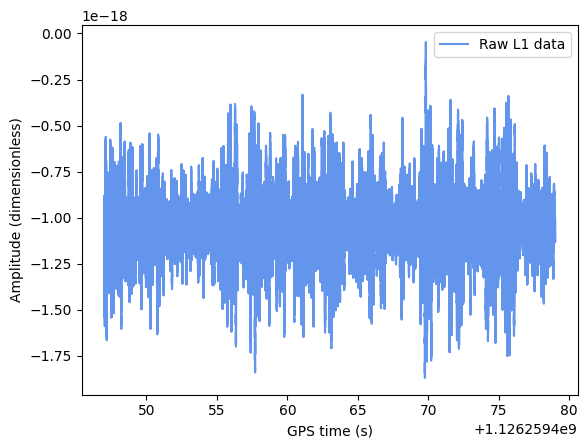

In [4]:
plt.plot(data.sample_times, data, label = 'Raw L1 data', color = 'cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton. 

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. 


**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency. 

Nyquist frequency has something to do with sample rate (half or double idk)

_Hint_: Note that the PSD is a frequency series.

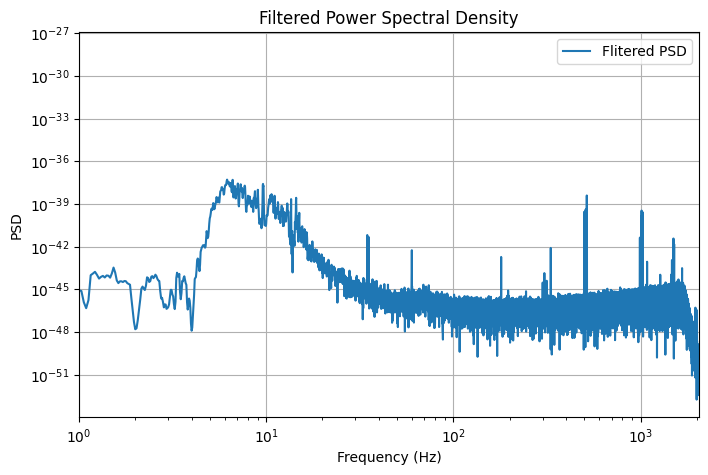

In [5]:
# Compute the PSD
psd = data.filter_psd(segment_duration = data.duration, delta_f = delta_f, flow = 1)

# Compute Nyquist Frequency
Nyquist = data.sample_rate / 2

# Set limits for my frequencoes
fmin = 1
fmax = Nyquist

# Plot, used ChatGPT
plt.figure(figsize = (8, 5))
plt.loglog(psd.sample_frequencies, psd, label = "Flitered PSD")
plt.xlim(fmin, fmax)  # Limit frequency to [1 Hz, Nyquist]
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Filtered Power Spectral Density")
plt.legend()
plt.grid()
plt.show()

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`. 

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


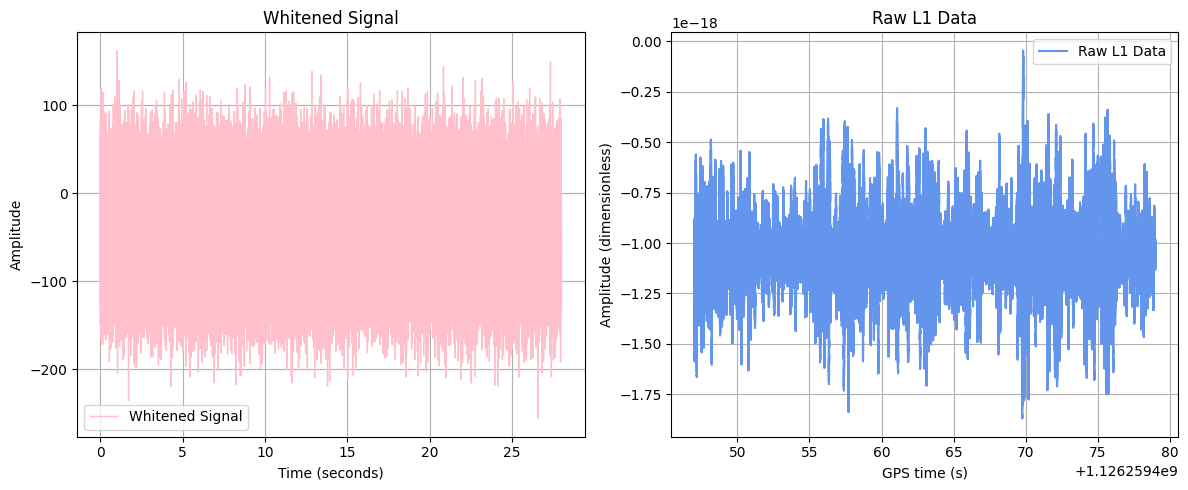

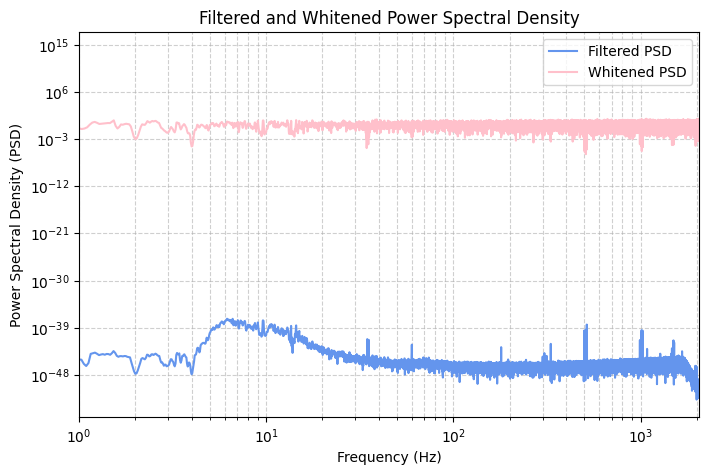

In [6]:
# Whitened data
whitened_data = data.whiten(segment_duration = 4, max_filter_duration = 4, trunc_method = 'hann', remove_corrupted = True, low_frequency_cutoff = None, return_psd = False)

# Create a time axis for the whitened data
time = np.arange(len(whitened_data)) / data.sample_rate  # Time in seconds
# Create a time axis for the raw data
time_raw = data.sample_times

# This is so I can have my plots one next to the other
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot whitened signal, inspired by Duck.ai
axes[0].plot(time, whitened_data, label = "Whitened Signal", color = 'pink', linewidth = 1)
axes[0].set_xlabel("Time (seconds)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Whitened Signal")
axes[0].legend()
axes[0].grid(True)

# Plot raw data, inspired by Duck.ai
axes[1].plot(time_raw, data, label = "Raw L1 Data", color = 'cornflowerblue')
axes[1].set_xlabel("GPS time (s)")
axes[1].set_ylabel("Amplitude (dimensionless)")
axes[1].set_title("Raw L1 Data")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Whitened PSD using filter_psd
whitened_psd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow = 1)

# Set labels and title
plt.figure(figsize = (8, 5))
plt.loglog(psd.sample_frequencies, psd, label = "Filtered PSD", color='cornflowerblue') # Plot the filtered PSD
plt.loglog(whitened_psd.sample_frequencies, whitened_psd, label="Whitened PSD", color='pink') # Plot the whitened PSD
plt.xlabel("Frequency (Hz)")
plt.xlim(fmin, fmax) # Set frequency limits
plt.ylabel("Power Spectral Density (PSD)")
plt.title("Filtered and Whitened Power Spectral Density")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()


Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data. 


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

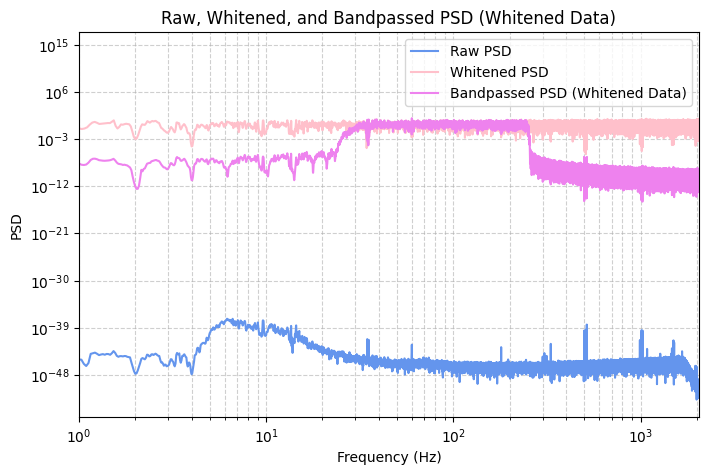

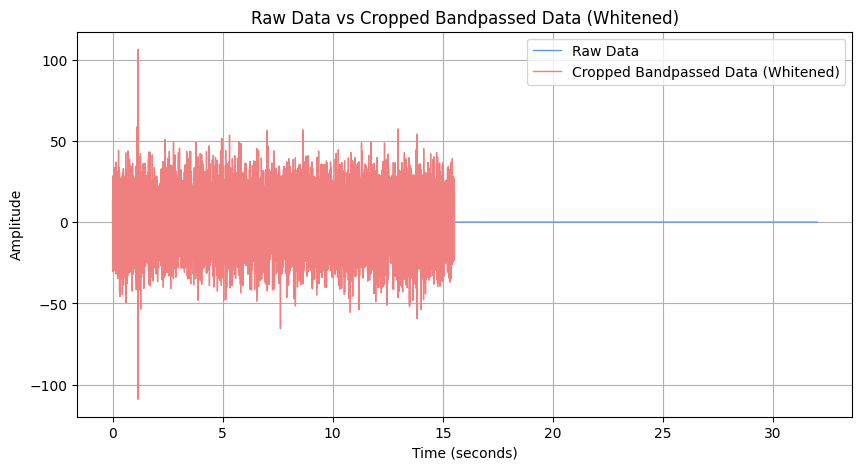

In [7]:
# Apply high-pass and low-pass filters to whitened data
data_bandpassed = whitened_data.highpass_fir(frequency=30, order=512)  # High-pass below 30 Hz
data_bandpassed = data_bandpassed.lowpass_fir(frequency=250, order=512)  # Low-pass above 250 Hz

# Estimate the PSD of the bandpassed whitened data
bandpassed_psd = data_bandpassed.filter_psd(segment_duration=data_bandpassed.duration, delta_f=delta_f, flow=1)

# Compute the raw PSD
psd_raw = data.filter_psd(segment_duration=data.duration, delta_f=delta_f, flow=1)

# Compute the whitened PSD
whitened_psd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow=1)

# Compute Nyquist Frequency
Nyquist = data.sample_rate / 2

# Set frequency limits
fmin = 1
fmax = Nyquist

# Plot all PSDs

# Labels and title
plt.figure(figsize=(8, 5))
plt.loglog(psd_raw.sample_frequencies, psd_raw, label = "Raw PSD", color = 'cornflowerblue') # Plot the raw PSD 
plt.loglog(whitened_psd.sample_frequencies, whitened_psd, label = "Whitened PSD", color = 'pink') # Plot the whitened PSD
plt.loglog(bandpassed_psd.sample_frequencies, bandpassed_psd, label = "Bandpassed PSD (Whitened Data)", color = 'violet') # Plot the bandpassed PSD (whitened data)
plt.xlabel("Frequency (Hz)")
plt.xlim(fmin, fmax)
plt.ylabel("PSD")
plt.title("Raw, Whitened, and Bandpassed PSD (Whitened Data)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()

# Crop 12 seconds from the left and 13 seconds from the right (which is why it is negative)
data_cropped = data_bandpassed.crop(12, -13)

# Create time axis for both cropped bandpassed and raw data
time = np.arange(len(data)) / data.sample_rate  # For raw data
time_cropped = np.arange(len(data_cropped)) / data.sample_rate  # For cropped bandpassed data

# Plot the cropped bandpassed data and raw data
plt.figure(figsize=(10, 5))

# Raw data
plt.plot(time, data, label="Raw Data", color='cornflowerblue', linewidth=1)

# Cropped bandpassed data (whitened data)
plt.plot(time_cropped, data_cropped, label="Cropped Bandpassed Data (Whitened)", color='lightcoral', linewidth=1)

# Set labels and title
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Raw Data vs Cropped Bandpassed Data (Whitened)")
plt.legend()
plt.grid(True)
plt.show()


**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

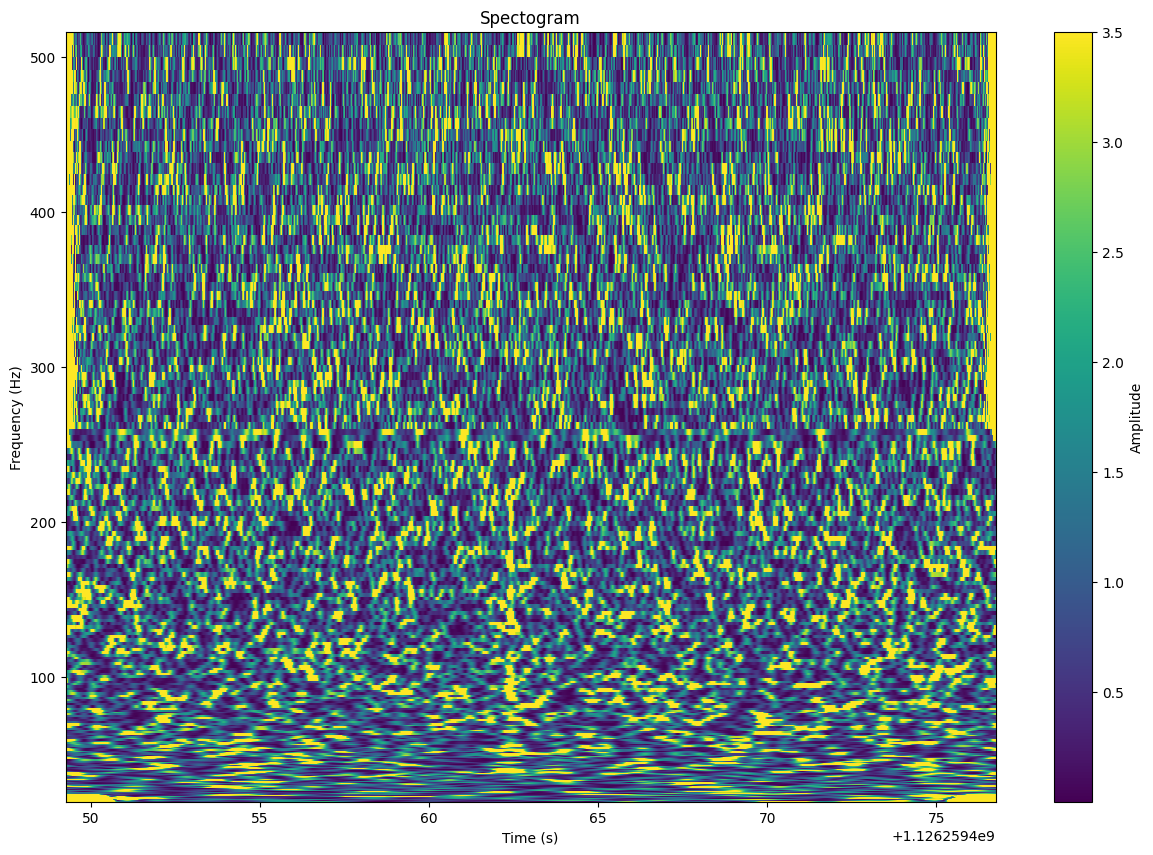

In [8]:
# Given parameters
logfsteps = 200 
qrange = (110, 110)
frange = (20, 512)
vmax = 3.5

# Perform a Q-transform on the bandpassed data to generate a time-frequency representation
# The Q-transform computes the signal's power across both time and frequency, using a logarithmic frequency scale and specified frequency range. 
# It returns the time bins, frequency bins, and the resulting power matrix of the transform.
times, freqs, q_tranform_result = data_bandpassed.qtransform(logfsteps = logfsteps, qrange = qrange, frange = frange)

# Plotting time
plt.figure(figsize = (15,10))
pylab.pcolormesh(times, freqs, q_tranform_result, vmax = vmax) # Inspired by classmate Guus
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectogram")
plt.colorbar(label = "Amplitude")
plt.show()

As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.937500 Hz, available 5000.000000 Hz)


Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.937500 Hz, available 5000.000000 Hz)
Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.937500 Hz, available 4995.378000 Hz)


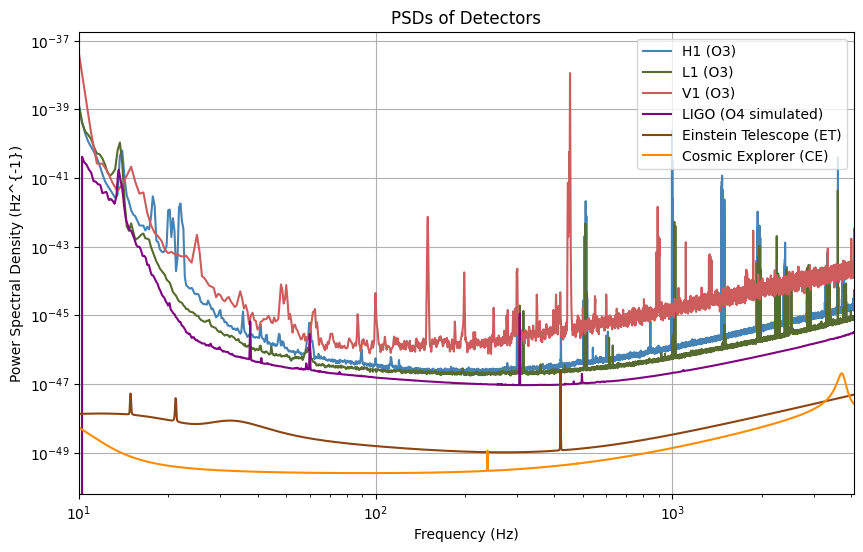

In [9]:
# Load the PSDs from the specified files
psd_H1_O3 = read.from_txt("aligo_O3actual_H1.txt", length = 16 * 8192, delta_f = 1 / 16, low_freq_cutoff = 10)
psd_L1_O3 = read.from_txt("aligo_O3actual_L1.txt", length = 16 * 8192, delta_f = 1 / 16, low_freq_cutoff = 10)
psd_V1_O3 = read.from_txt("avirgo_O3actual.txt", length = 16 * 8192, delta_f = 1 / 16, low_freq_cutoff = 10)
psd_LIGO_O4 = read.from_txt("aligo_O4high.txt", length = 16 * 8192, delta_f = 1 / 16, low_freq_cutoff = 10.3)

# Load the Einstein Telescope (ET) and Cosmic Explorer (CE) analytical PSDs
psd_ET = pycbc.psd.analytical.EinsteinTelescopeP1600143(length = 16 * 8192, delta_f = 1 / 16, low_freq_cutoff = 10)
psd_CE = pycbc.psd.analytical.CosmicExplorerP1600143(length = 16 * 8192, delta_f = 1 / 16, low_freq_cutoff = 10)

# Set the frequency range
fmin = 10  # Hz, as per the hint
fmax = 4096  # Nyquist frequency (sample_rate / 2)

# Set the sampling rate and duration
sample_rate = 8192  # Hz
duration = 16  # seconds

# Plot the PSDs
plt.figure(figsize=(10, 6))

# Plot the PSDs for each detector
plt.loglog(psd_H1_O3.sample_frequencies, psd_H1_O3, label = "H1 (O3)", color = 'steelblue')
plt.loglog(psd_L1_O3.sample_frequencies, psd_L1_O3, label = "L1 (O3)", color = 'darkolivegreen')
plt.loglog(psd_V1_O3.sample_frequencies, psd_V1_O3, label = "V1 (O3)", color = 'indianred')
plt.loglog(psd_LIGO_O4.sample_frequencies, psd_LIGO_O4, label = "LIGO (O4 simulated)", color = 'purple')

# Plot the Einstein Telescope and Cosmic Explorer PSDs
plt.loglog(psd_ET.sample_frequencies, psd_ET, label = "Einstein Telescope (ET)", color = 'saddlebrown')
plt.loglog(psd_CE.sample_frequencies, psd_CE, label = "Cosmic Explorer (CE)", color = 'darkorange')

# Plot
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (Hz^{-1})")
plt.title("PSDs of Detectors")
plt.xlim(fmin, fmax) # Set frequency limits
plt.legend()
plt.grid(True)
plt.show()


Good job! This is the end of the second part. Maybe you can go for a break?